<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainPhaseAndArmAndNumSubjectsClassifier_10_Keras_longer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

# df_annotations = pd.read_csv("all_annotations.csv")


# Get data

In [2]:
# with open("protocols.pkl.gz", "rb") as f:
#     file_to_pages = pkl.load(f)

In [3]:
# import spacy
# nlp = spacy.blank("en")

In [4]:
# texts = []

# for i in range(len(df_annotations)):
#     file_name = df_annotations.file.iloc[i]
    
#     pages= file_to_pages[file_name]
    
#     text = ""
#     for page in pages:
#         doc = nlp(page)
        
#         is_include = [False] * len(doc)
#         for tok in doc:
#             if tok.text.lower() in {"phase"}:
#                 for token_index in range(tok.i - 20, tok.i + 20):
#                     if token_index >= 0 and token_index < len(doc):
#                         is_include[token_index] = True
        
#         for token_index in range(len(doc)):
#             if is_include[token_index]:
#                 text += doc[token_index].text + doc[token_index].whitespace_
                
                
#     if text == "":
#         print ("nothing found", file_name, df_annotations.phase.iloc[i])
#         text = " ".join(pages)
#         if len(text) > 100000:
#             text = text[:100000]
#     else:
#         print ("found", file_name, df_annotations.phase.iloc[i])

#     texts.append(text)
# df_annotations["text"] = texts

In [5]:
# df_annotations.to_csv("filtered_for_phase.csv.bz2")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_annotations= pd.read_csv("/content/drive/MyDrive/data/filtered_for_phase_arms_subjects_02.csv.bz2")

In [8]:
#df_annotations.text = df_annotations.text.apply(lambda t : t[:10000] if len(t) > 10000 else t)

In [9]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    if num >= 10000:
        return "10000+"
    if num >= 1000:
        return "1000+"
    if num >= 500:
        return "500+"
    if num >= 200:
        return "200+"
    if num >= 100:
        return "100+"
    if num >= 50:
        return "50+"
    if num >= 25:
        return "25+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

In [10]:
df_annotations["num_subjects_clean"].value_counts()

1-24      2980
25+       2119
50+       2016
100+      1674
200+      1656
500+       816
1000+      547
10000+     112
Name: num_subjects_clean, dtype: int64

In [11]:
# df_annotations = pd.read_csv("filtered_for_phase.csv.bz2")

In [12]:
# del file_to_pages

In [13]:
phase_map = {"Phase 2":"2",
"Phase 3":"3",
"Phase 4":"4",
"Phase 1":"1",
"Phase 1/Phase 2":"1.5",
"Not Applicable":"0",
"Phase 2/Phase 3":"2.5",
"Early Phase 1":"0.5"}
df_annotations["phase_clean"] = df_annotations["phase"].apply(lambda x : phase_map.get(x, None))

In [14]:
phase_clean_map = {}
for idx, val in enumerate(sorted(set(phase_map.values()), key = lambda x : float(x))):
  phase_clean_map[val] = idx
# invert the dictionary
phase_lookup = {v: k for k, v in phase_clean_map.items()}

phase_list = [phase_lookup[x] for x in sorted(phase_lookup)]
phase_list

['0', '0.5', '1', '1.5', '2', '2.5', '3', '4']

In [15]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 5:
        num = 5
    return num
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

# Begin Keras/TF

In [16]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [17]:
num_subjects_clean_map = {}
for idx, val in enumerate(sorted(set(df_annotations[~df_annotations.num_subjects_clean.isna()].num_subjects_clean), key = lambda x : int(re.sub(r'\D.*$', '', x)))):
  num_subjects_clean_map[val] = idx

In [18]:
# invert the dictionary
num_subjects_lookup = {v: k for k, v in num_subjects_clean_map.items()}

In [19]:
num_subjects_list = [num_subjects_lookup[x] for x in sorted(num_subjects_lookup)]
num_subjects_list

['1-24', '25+', '50+', '100+', '200+', '500+', '1000+', '10000+']

In [20]:
num_subjects_clean_map

{'1-24': 0,
 '25+': 1,
 '50+': 2,
 '100+': 3,
 '200+': 4,
 '500+': 5,
 '1000+': 6,
 '10000+': 7}

In [21]:
def get_one_hot_num_subjects(x):
  a = [0] * len(num_subjects_clean_map)
  if x is None:
    return a
  a[num_subjects_clean_map[x]] = 1
  return a

In [22]:
df_annotations["num_subjects_one_hot"] = df_annotations["num_subjects_clean"].apply(get_one_hot_num_subjects)

In [24]:
def get_one_hot_num_arms(x):
  a = [0] * 5
  if x is not None and not pd.isna(x):
    a[int(x - 1)] = 1
  return a
df_annotations["num_arms_one_hot"] = df_annotations["num_arms_clean"].apply(get_one_hot_num_arms)

In [25]:
def get_one_hot_phase(x):
  a = [0] * len(phase_clean_map)
  if x is None:
    return a
  a[phase_clean_map[x]] = 1
  return a
df_annotations["phase_one_hot"] = df_annotations["phase_clean"].apply(get_one_hot_phase)

Concatenate the three bits of one-hot data into one column

In [26]:
concatenated_one_hot = []
for i in range(len(df_annotations)):
  concatenated = list(df_annotations.phase_one_hot.iloc[i]) + \
  list(df_annotations.num_arms_one_hot.iloc[i]) + \
  list(df_annotations.num_subjects_one_hot.iloc[i]) + [df_annotations.has_sap.iloc[i]]
  concatenated_one_hot.append(concatenated)
df_annotations["concatenated_one_hot"] = concatenated_one_hot

In [27]:
np.sum(np.asarray([np.asarray(x) for x in df_annotations["concatenated_one_hot"]]), axis=1).mean()

nan

In [28]:
np.sum(np.asarray([np.asarray(x) for x in df_annotations["concatenated_one_hot"]]), axis=0)

array([ 519.,  135., 1154.,  983., 4317.,  297., 2725., 1461., 3086.,
       5228., 1456.,  908.,  913., 2980., 2119., 2016., 1674., 1656.,
        816.,  547.,  112.,   nan])

In [29]:
num_classes = len(concatenated)
print (f"There are {num_classes} classes in this multi-label classifier")

There are 22 classes in this multi-label classifier


In [30]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [31]:
df_train_got_some_ground_truths = df_train[~df_train.num_subjects_clean.isna() | ~df_train.num_arms_clean.isna() | ~df_train.phase_clean.isna()]

In [32]:
len(df_train_got_some_ground_truths), len(df_train)

(9535, 9538)

In [33]:
train_labels = np.asarray(list(df_train_got_some_ground_truths.concatenated_one_hot))
test_labels = np.asarray(list(df_val.concatenated_one_hot))

In [34]:
train_examples = np.asarray(list(df_train_got_some_ground_truths.text))
test_examples = np.asarray(list(df_val.text))

In [35]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 9535, test entries: 1085


In [36]:
train_labels[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,

In [43]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 3.8062613e+00, -8.5627154e-02,  2.1885273e+00,  1.2064425e+00,
         1.1741788e+00, -1.6362848e+00, -1.6544684e+00,  1.9301386e+00,
        -7.3246288e-01, -2.0803753e-01, -1.8835599e+00, -8.1751305e-01,
         1.3482304e+00, -4.1169381e+00,  1.1123058e+00, -2.7861402e+00,
         3.6909611e+00, -2.2455294e+00,  1.1222224e+00,  1.9886566e+00,
        -1.0249604e-01,  2.6178288e+00,  3.5085483e+00, -7.0547515e-01,
         1.2558808e+00, -1.6434602e+00, -1.1090916e+00,  4.3890409e+00,
        -1.7149318e+00, -2.8435621e+00,  1.0796951e+00,  2.6536503e+00,
        -3.8684306e-01, -3.1688907e+00,  1.0274379e-01, -2.0242805e+00,
         2.3353672e+00, -1.7880658e+00,  5.3773862e-01, -1.0440906e+00,
        -9.3668759e-01, -1.6973139e+00, -1.4264782e-01,  2.6114061e+00,
         5.0076956e-01, -1.2994319e+00,  9.0301037e-01, -1.4811747e+00,
         8.1332225e-01,  2.3800061e+00],
       [ 2.5299299e+00,  6.9842733e-02,  1.220

In [44]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 22)                374       
                                                                 
Total params: 48,191,790
Trainable params: 48,191,790
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy'), tf.metrics.AUC(name='auc')],
              run_eagerly=True)

In [46]:
# x_val = train_examples[:10000]
# partial_x_train = train_examples[10000:]

# y_val = train_labels[:10000]
# partial_y_train = train_labels[10000:]

partial_x_train = train_examples
x_val = test_examples

partial_y_train = train_labels
y_val = test_labels

In [42]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
19/19 [==============================] - 5s 280ms/step - loss: 0.6225 - accuracy: 0.6755 - auc: 0.5407 - val_loss: 0.5476 - val_accuracy: 0.7465 - val_auc: 0.5439
Epoch 2/100
19/19 [==============================] - 5s 262ms/step - loss: 0.5071 - accuracy: 0.7918 - auc: 0.5723 - val_loss: 0.4671 - val_accuracy: 0.8307 - val_auc: 0.6227
Epoch 3/100
19/19 [==============================] - 5s 264ms/step - loss: 0.4421 - accuracy: 0.8434 - auc: 0.6544 - val_loss: 0.4190 - val_accuracy: 0.8486 - val_auc: 0.6890
Epoch 4/100
19/19 [==============================] - 5s 263ms/step - loss: 0.4055 - accuracy: 0.8529 - auc: 0.7148 - val_loss: 0.3960 - val_accuracy: 0.8543 - val_auc: 0.7304
Epoch 5/100
19/19 [==============================] - 5s 263ms/step - loss: 0.3883 - accuracy: 0.8564 - auc: 0.7422 - val_loss: 0.3854 - val_accuracy: 0.8561 - val_auc: 0.7453
Epoch 6/100
19/19 [==============================] - 5s 262ms/step - loss: 0.3783 - accuracy: 0.8579 - auc: 0.7565 - val_loss

In [47]:
model.save('phase_arm_num_subjects_model_10_keras.keras')

In [48]:
model.save("/content/drive/MyDrive/data/phase_arm_num_subjects_model_10_keras.keras")

In [49]:
results = model.evaluate(test_examples, test_labels)

print(results)

34/34 [==============================] - 1s 29ms/step - loss: 0.8922 - accuracy: 0.4183 - auc: 0.4214
[0.892178475856781, 0.41826561093330383, 0.42143940925598145]


In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

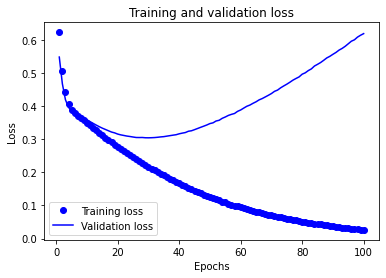

In [51]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

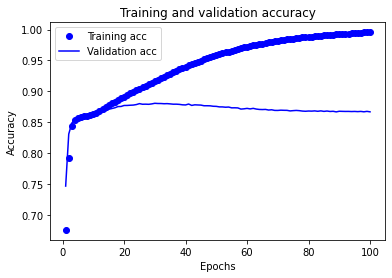

In [52]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [53]:
input_texts= np.asarray(df_val.text)

In [54]:
pred_proba = model.predict(input_texts)

34/34 [==============================] - 1s 17ms/step


In [55]:
y_pred_phase = []
y_pred_num_arms = []
y_pred_num_subjects = []
y_pred_sap = []
for idx in range(len(pred_proba)):
  probas_this_instance = pred_proba[idx]
  probas_phase = probas_this_instance[:len(phase_lookup)]
  y_pred_phase.append(phase_lookup[int(np.argmax(probas_phase))])
  probas_arms = probas_this_instance[len(phase_lookup):len(phase_lookup)+5]
  y_pred_num_arms.append(1 + int(np.argmax(probas_arms)))
  probas_subjects = probas_this_instance[len(phase_lookup)+5:-1]
  y_pred_num_subjects.append(num_subjects_lookup[int(np.argmax(probas_subjects))])
  probas_sap = probas_this_instance[-1:]
  y_pred_sap.append(probas_sap[0] > 0.5)

df_val["y_pred_phase"] = y_pred_phase
df_val["y_pred_num_arms"] = y_pred_num_arms
df_val["y_pred_num_subjects"] = y_pred_num_subjects
df_val["y_pred_sap"] = y_pred_sap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Phase

In [56]:
acc = accuracy_score(df_val.phase_clean.apply(str), df_val["y_pred_phase"])
print (f"Phase accuracy {acc}")

Phase accuracy 0.10783410138248847


''

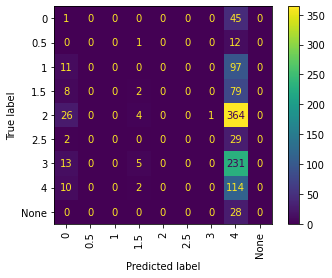

In [57]:
ConfusionMatrixDisplay.from_predictions(df_val.phase_clean.apply(str), df_val["y_pred_phase"])
plt.xticks(rotation=90)
;

# Number of arms

In [58]:
acc = accuracy_score(df_val.num_arms_clean.apply(float).apply(str), df_val["y_pred_num_arms"].apply(float).apply(str))
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.10599078341013825


''

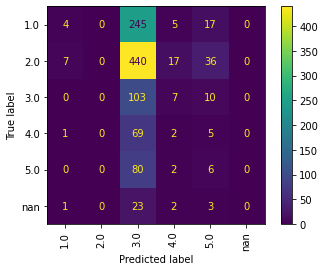

In [59]:
ConfusionMatrixDisplay.from_predictions(df_val.num_arms_clean.apply(float).apply(str), df_val["y_pred_num_arms"].apply(float).apply(str))
plt.xticks(rotation=90)
;

## Subjects

In [60]:
acc = accuracy_score(df_val.num_subjects_clean, df_val["y_pred_num_subjects"])
print (f"Subjects accuracy {acc}")

Subjects accuracy 0.055299539170506916


''

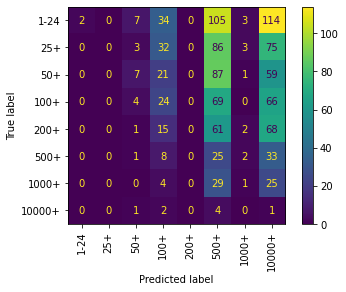

In [61]:
ConfusionMatrixDisplay.from_predictions(df_val.num_subjects_clean, df_val["y_pred_num_subjects"], labels=num_subjects_list)
plt.xticks(rotation=90)
;

In [62]:
num_correct = 0
for idx in range(len(df_val)):
  gt = num_subjects_clean_map[df_val["num_subjects_clean"].iloc[idx]]
  pred = num_subjects_clean_map[df_val["y_pred_num_subjects"].iloc[idx]]
  is_correct = int(np.abs(gt - pred) <= 1)
  num_correct += is_correct
print ("Accuracy including adjacent groups", num_correct/len(df_val))

Accuracy including adjacent groups 0.20276497695852536


## SAP

In [63]:
acc = accuracy_score(df_val.has_sap, df_val["y_pred_sap"])
print (f"SAP accuracy {acc}")

SAP accuracy 0.4967741935483871


''

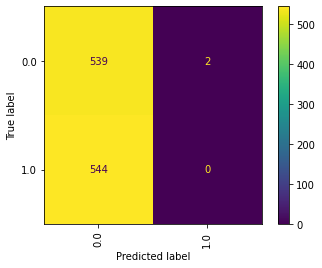

In [64]:
ConfusionMatrixDisplay.from_predictions(df_val.has_sap, df_val["y_pred_sap"])
plt.xticks(rotation=90)
;